# Drone Routing Optimization Problem

## Model Initialization

In [1]:
# import Glop linear solver package
from ortools.linear_solver import pywraplp as glp
import csv
import numpy as np
import pandas as pd
import time
from datetime import date

# initialize model object
mymodel = glp.Solver('Drone Routing Problem', glp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

In [2]:
# Set filepath for CSV with cost / distance data
cost_filepath = 'Orders_Data_15.csv' # file with distances between each node
coord_filepath = 'XYcoord_15.csv' # file with x, y coordinates of each node (including the origin)

## Parameters

### Import distance matrix

In [3]:
# import csv distance matrix as list
with open(cost_filepath, newline='') as f:
    reader = csv.reader(f)
    distance = list(reader)

# remove blanks
for i in range(len(distance)):
    distance[i] = [item for item in distance[i] if item]
distance = [item for item in distance if item]
distance = np.array(distance, dtype = 'float')

# Cost per unit of distance
truck_cost_per_dist = 10.0
drone_cost_per_dist = 3.0

# Create cost matrices for truck & drone
truck_cost = distance * truck_cost_per_dist
drone_cost = distance * drone_cost_per_dist * 2 # Multiply by 2 to account for out / back path of drone
truck_cost = truck_cost.tolist()
drone_cost = drone_cost.tolist()

### Initialize Model Parameters

In [4]:
# model parameters
N = len(distance)
M = N + 100 # Large number
D = 2 # Drones onboard the truck (0 to 2 index)

## Decision Variables

In [5]:
# Truck path from node i to j
truck_arc = np.zeros((N,N)).tolist() # create nested list
for i in range(N):
    for j in range(N):
        truck_arc[i][j] = mymodel.IntVar(0, 1, "truck_" + str(i) + "." + str(j)) #create binary variable for each possible truck path

In [6]:
# The kth drone path from node i to j

drone_arc = np.zeros((N,N)).tolist() # create nested list

for i in range(N):
    for j in range(N):
        drone_arc[i][j] = mymodel.IntVar(0, 1, 'drone_' + str(i) + "." + str(j)) #create binary variable for each possible drone path

In [7]:
# create position variable (lambda / u)
pos = list(range(N))
for i in range(N):
    pos[i] = mymodel.IntVar(1, N-1, "p." + str(i))
pos[0].SetLb(0)
pos[0].SetUb(0)

## Objective

In [8]:
# create objective function
optimal_route = mymodel.Objective()
optimal_route.SetMinimization() # Minimize cost

for i in range(N):
    for j in range(N):
        if i != j: optimal_route.SetCoefficient(truck_arc[i][j], truck_cost[i][j]) # Truck cost per arc
        
for i in range(N):
    for j in range(N):
        if i != j: optimal_route.SetCoefficient(drone_arc[i][j], drone_cost[i][j]) # Drone cost per arc


## Constraints

In [9]:
first_arc = mymodel.Constraint(1,1)
for j in range(1,N):
    first_arc.SetCoefficient(truck_arc[0][j], 1)

In [10]:
last_arc = mymodel.Constraint(1,1)
for i in range(1,N):
    last_arc.SetCoefficient(truck_arc[i][0], 1)

In [11]:
bal = list(range(N))
for j in range(N):
    bal[j] = mymodel.Constraint(0, 0)
    for i in range(N):
        bal[j].SetCoefficient(truck_arc[i][j], 1)
        bal[j].SetCoefficient(truck_arc[j][i], -1)

In [12]:
launch = np.zeros(N).tolist()
for i in range(1,N):
    launch[i] = mymodel.Constraint(-D, 0)
    for j in range(1,N):
        launch[i].SetCoefficient(drone_arc[i][j], 1)
    for k in range(N):
        launch[i].SetCoefficient(truck_arc[k][i], -D)

In [13]:
coverage = list(range(N))
for j in range(1,N):
    coverage[j] = mymodel.Constraint(1, 1)
    for i in range(N):
        if i!=j: coverage[j].SetCoefficient(truck_arc[i][j], 1)
    for i in range(1,N):
        coverage[j].SetCoefficient(drone_arc[i][j], 1)

In [14]:
MTZ = np.zeros((N,N)).tolist() # create nested list

for i in range(N):
    for j in range(1,N):
        MTZ[i][j] = mymodel.Constraint(-mymodel.infinity(), N-2)
        MTZ[i][j].SetCoefficient(truck_arc[i][j], N-1)
        MTZ[i][j].SetCoefficient(pos[i], 1)
        MTZ[i][j].SetCoefficient(pos[j], -1)

In [15]:
mymodel.NumVariables()

903

In [16]:
mymodel.NumConstraints()

483

In [17]:
# Solve the model and print optimal solution
start_time = time.time()
status = mymodel.Solve()                 # solve mymodel and display the solution

print('Solution Status =', status)
print('Number of variables =', mymodel.NumVariables())
print('Number of constraints =', mymodel.NumConstraints())

print('Optimal Solution:')

# The objective value of the solution.
print('Optimal Value = %.2f' % optimal_route.Value())

print("Solution Time: %.2f seconds" % (time.time() - start_time))
runtime = round(time.time() - start_time)
today = str(date.today())

# Display optimal solution
for i in range(N):
    print('pos[%d] = %d' % (i, pos[i].solution_value()))
    for j in range(N):
        if truck_arc[i][j].solution_value() == 1:
            print('Truck ', i, ' to ', j, ': ', truck_arc[i][j].solution_value(), sep = '')
for i in range(1,N):
    for j in range(1,N):
        if drone_arc[i][j].solution_value() == 1:
                print('Drone from ', i, ' to ', j, ': ', drone_arc[i][j].solution_value(), sep = '')
        #for k in D:

Solution Status = 0
Number of variables = 903
Number of constraints = 483
Optimal Solution:
Optimal Value = 3914.96
Solution Time: 6605.25 seconds
pos[0] = 0
Truck 0 to 3: 1.0
pos[1] = 1
pos[2] = 20
pos[3] = 1
Truck 3 to 6: 1.0
pos[4] = 1
pos[5] = 1
pos[6] = 2
Truck 6 to 12: 1.0
pos[7] = 20
Truck 7 to 0: 1.0
pos[8] = 1
pos[9] = 20
pos[10] = 1
pos[11] = 18
Truck 11 to 16: 1.0
pos[12] = 3
Truck 12 to 18: 1.0
pos[13] = 1
pos[14] = 1
pos[15] = 1
pos[16] = 19
Truck 16 to 7: 1.0
pos[17] = 17
Truck 17 to 11: 1.0
pos[18] = 4
Truck 18 to 19: 1.0
pos[19] = 5
Truck 19 to 17: 1.0
pos[20] = 1
Drone from 3 to 10: 1.0
Drone from 6 to 8: 1.0
Drone from 6 to 9: 1.0
Drone from 7 to 13: 1.0
Drone from 11 to 20: 1.0
Drone from 12 to 2: 1.0
Drone from 16 to 15: 1.0
Drone from 17 to 1: 1.0
Drone from 18 to 4: 1.0
Drone from 18 to 14: 1.0
Drone from 19 to 5: 1.0


In [18]:
Position = []
From = []
To = []

for i in range(N):
    #Position.append(int(pos[i].solution_value() + 1))
    for j in range(N):
        if truck_arc[i][j].solution_value() == 1:
            From.append(i)
            To.append(j)
        if drone_arc[i][j].solution_value() == 1:
            From.append(i)
            To.append(j)
solution = pd.DataFrame(list(zip(From, To)), columns = ['From', 'To'])
solution = solution.sort_values(by=['From', 'To'], ascending=[True, False]).reset_index(drop=True)
solution

,From,To
0,0,3
1,3,10
2,3,6
3,6,12
4,6,9
5,6,8
6,7,13
7,7,0
8,11,20
9,11,16


## Plot the Solution

In [19]:
import matplotlib.pyplot as plt
import networkx as nx

In [20]:
# import csv x, y coord matrix as list
with open(coord_filepath, newline='') as f:
    reader = csv.reader(f)
    coord = list(reader)

# remove blanks & converting to integers
for i in range(len(coord)):
    coord[i] = [int(item) for item in coord[i] if item]
coord = [item for item in coord if item]

In [21]:
# Define function to convert list of coordinates to dictionary
def to_dict(my_list):
    dict = {}
    for items in range(len(my_list)):
        dict[items] = my_list[items]
    return dict

In [22]:
coord = to_dict(coord)
coord

{0: [0, 0],
 1: [76, 98],
 2: [85, 6],
 3: [24, 10],
 4: [100, 47],
 5: [81, 77],
 6: [64, 7],
 7: [1, 61],
 8: [61, 24],
 9: [64, 5],
 10: [31, 23],
 11: [45, 70],
 12: [77, 11],
 13: [2, 90],
 14: [99, 61],
 15: [47, 91],
 16: [37, 74],
 17: [62, 78],
 18: [96, 50],
 19: [74, 65],
 20: [50, 56]}

In [23]:
# Define edge list
edge_list = []
for i in range(len(solution)):
    edge_list.append([solution['From'][i], solution['To'][i]])

In [24]:
# Initialize graph object
G = nx.Graph()

C:\Users\camco\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


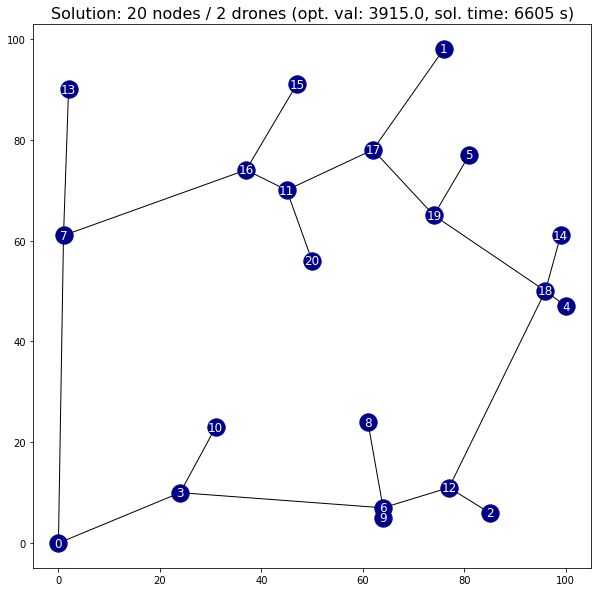

In [25]:
for (u,v) in edge_list:
    G.add_edge(v, u, capacity=1) 
       
fig, ax = plt.subplots(figsize=(10,10))
nx.draw(G, coord, edgelist=edge_list, edge_labels=True, with_labels=True, font_color='w', node_color='darkblue', ax=ax)
#nx.draw_networkx_edges(G, coord, edgelist=droneedgelist, edge_color='darkorange', style='dotted', ax=ax)
limits=plt.axis('on')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
opt_val = round(optimal_route.Value(), 1)
string = 'Solution: ' + str(N-1) + ' nodes / ' + str(D) +' drones (opt. val: ' + str(opt_val) + ', ' 'sol. time: ' + str(runtime) + ' s)'
ax.set_title(string, fontsize = 16)
plt.show();
saveas = 'Drone_output_' + str(N-1) +'n_' + str(D) + 'd_'+ today  +'.png'
fig.savefig(saveas);

### Save solution as CSV

In [26]:
saveas_csv = 'Drone_output_' + str(N-1) +'n_' + str(D) + 'd_'+ today +'.csv'
solution.to_csv(saveas_csv, index=False)